<a href="https://colab.research.google.com/github/GrueneKatze/AI-for-Medicine-Coursera/blob/master/Pneumonia_detection_with_FastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import os

In [3]:
!pip install -q pydicom

     |████████████████████████████████| 35.3MB 89kB/s 


In [0]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as pydicom
#%matplotlib inline 



In [0]:
import imageio
import PIL
import json, pdb

In [0]:
#import zipfile
with zipfile.ZipFile(path_rsna/'stage_2_detailed_class_info.csv.zip', 'r') as zip_ref:
  zip_ref.extractall(path_rsna)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path_rsna = Path(base_dir + 'data/rsna')

In [0]:
path_images = Path(base_dir + 'data/rsna/images')
path_images.mkdir(parents=True, exist_ok=True)

In [0]:
path_m = Path(base_dir + 'data/rsna/models')
path_m.mkdir(parents=True, exist_ok=True)

In [12]:
print(os.listdir(path_rsna))

['.ipynb_checkpoints', 'stage_2_train_images.zip', 'stage_2_train_labels.csv.zip', 'images', 'stage_2_train_labels.csv']


In [15]:
path_rsna.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/.ipynb_checkpoints'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/stage_2_train_labels.csv.zip'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/images'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/stage_2_train_labels.csv'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/stage_2_detailed_class_info.csv.zip'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/stage_2_detailed_class_info.csv')]

##Exploring & preprocessing data



In [0]:
train_labels_df = pd.read_csv(path_rsna/'stage_2_train_labels.csv')

In [16]:
print(f"Train labels -  rows: {train_labels_df.shape[0]}, columns: {train_labels_df.shape[1]}")

Train labels -  rows: 30227, columns: 6


In [13]:
train_labels_df.sample(10)

,patientId,x,y,width,height,Target
24404,db5399f8-e0cb-4208-8694-a7136f9ac574,378.0,310.0,111.0,130.0,1
13248,859a8249-1e52-4a1a-9d35-e1cd84389c28,171.0,488.0,234.0,346.0,1
17236,a5193f5a-e9f4-4e32-a520-5b06d13f1d2a,239.0,555.0,212.0,247.0,1
11045,73c536ff-9071-44d0-8b4e-1445ad87894b,NaN,NaN,NaN,NaN,0
15474,972fd317-0c35-4a56-aca3-4dcf1ec1fb95,NaN,NaN,NaN,NaN,0
14318,8dd1f921-b6ef-4a4a-b878-d20b1c5007f5,NaN,NaN,NaN,NaN,0
25588,e51ae9d8-2e5b-40a1-89fd-06b60fd64355,670.0,404.0,161.0,177.0,1
21525,c3b9c35d-19a1-4ce7-b852-e670dce72ddc,606.0,543.0,146.0,195.0,1
13615,8889bc30-6951-4d72-89c4-48a193f88df4,NaN,NaN,NaN,NaN,0
3463,388d9b4f-6c31-44ac-b878-8f5c3843fd1f,215.0,437.0,204.0,174.0,1


In [0]:
class_info_df = pd.read_csv(path_rsna/'stage_2_detailed_class_info.csv')

In [17]:
class_info_df.sample(10)

,patientId,class
18645,af59f4a2-32d4-4888-ac7f-fc0bcc23abd2,Lung Opacity
4447,3efe3e31-90f3-42a2-ae15-70f8906f14ec,Lung Opacity
789,0a63a331-3e17-4e23-8a9f-f7a4ec850a1b,Normal
13704,89492f31-d3a7-4e3f-b715-efa858eb1c8c,Lung Opacity
6588,4ffc98be-0e13-4fe7-b4fe-248b232b7360,Normal
21220,c08bb1c2-97a3-4dfc-babd-aae561c3ab68,No Lung Opacity / Not Normal
22821,cddc6ce3-acd9-46d2-a76f-8dae7d9245e4,Normal
6472,4f34c638-80de-4e77-92c7-87ccd0453b32,Lung Opacity
22906,ce9b09db-1e6c-4924-b070-a9fd407d0bea,No Lung Opacity / Not Normal
17150,a48ea42a-4ce7-4216-af83-8a022c2fb952,No Lung Opacity / Not Normal


In [18]:
class_info_df.isnull().any()

patientId    False
class        False
dtype: bool

In [19]:
train_labels_df.isnull().any()

patientId    False
x             True
y             True
width         True
height        True
Target       False
dtype: bool

In [0]:
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

In [21]:
train_class_df.sample(10)

,patientId,x,y,width,height,Target,class
37242,2ac47932-d7e2-4ac2-a7c6-6a9be0c4abcd,732.0,211.0,97.0,210.0,1,Lung Opacity
13692,72f5ea03-e82b-4062-8e3e-32bdd8d3229c,613.0,513.0,226.0,167.0,1,Lung Opacity
5794,3ca6661a-ffbd-4d4d-b49b-c96cfd218307,549.0,82.0,280.0,942.0,1,Lung Opacity
1767,13ef2d8e-3b2e-4fbb-9f70-69139dd74401,192.0,358.0,169.0,334.0,1,Lung Opacity
27508,c400835c-47b2-46bd-9782-223e14d3090f,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
35000,f9c4f02b-52b5-4f36-96d7-b706d678d9b9,171.0,435.0,169.0,173.0,1,Lung Opacity
77,01be392f-a46d-4aef-a57e-9cd1a80dd47e,175.0,825.0,168.0,109.0,1,Lung Opacity
30596,da989823-20a8-4d10-bfe6-d513ee83ee5e,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
27110,c23444bf-fd79-4fee-81eb-521e9fce470e,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
4178,3543c982-375a-45f3-92d2-8a6e2f8a39af,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [0]:
#convert class data into one-hot encoding format
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
class_enc = LabelEncoder()
train_class_df['class_idx'] = class_enc.fit_transform(train_class_df['class'])
oh_enc = OneHotEncoder(sparse=False)
train_class_df['class_vec'] = oh_enc.fit_transform(
    train_class_df['class_idx'].values.reshape(-1, 1)).tolist() 
train_class_df.sample(3)

In [0]:
#split to train and val sets
from sklearn.model_selection import train_test_split
image_df = train_class_df.groupby('patientId').apply(lambda x: x.sample(1))
raw_train_df, valid_df = train_test_split(image_df, test_size=0.25, random_state=2018,
                                    stratify=image_df['class'])
print(raw_train_df.shape, 'training data')
print(valid_df.shape, 'validation data')

In [0]:
def open_dcm_image(fn:PathOrStr,convert_mode:str='RGB',after_open:Callable=None)->Image:
  "Return `Image` object created from image in file `fn`."
  array = pydicom.dcmread(fn).pixel_array
  x = PIL.Image.fromarray(array).convert('RGB')
  return Image(pil2tensor(x,np.float32).div_(255))

In [0]:
vision.data.open_image = open_dcm_image

In [18]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0)
# Creating Image DataBunch
data = ImageDataBunch.from_csv(path_rsna,folder='images',csv_labels='stage_2_train_labels.csv',ds_tfms=tfms,fn_col='patientId',label_col='Target',suffix='.dcm',seed=47,size=224)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


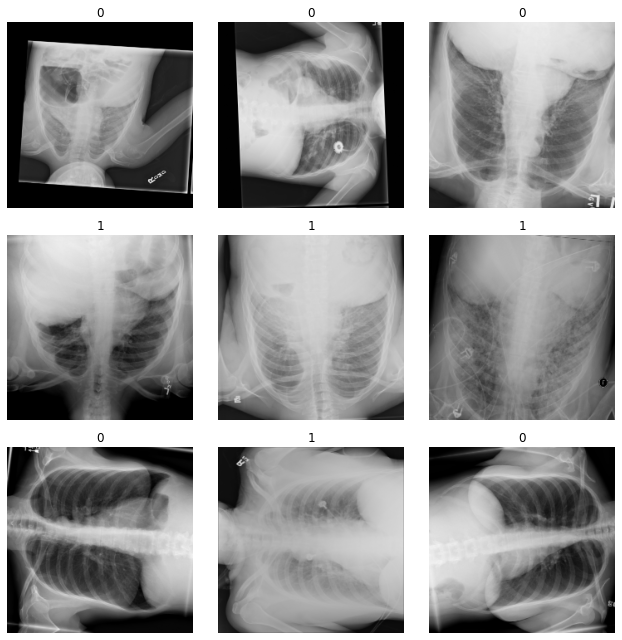

In [19]:
data.show_batch(rows=3, figsize=(9,9))

##Defining model

In [20]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy,error_rate])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn.fit_one_cycle(2)

In [0]:
learn.save(path_m/'1a')

##To delete

In [0]:
import pydicom
import pylab

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

In [0]:
!pip install tensorflow-io

     |████████████████████████████████| 20.1MB 1.3MB/s 
     |████████████████████████████████| 421.8MB 27kB/s 
     |████████████████████████████████| 3.9MB 49.9MB/s 
     |████████████████████████████████| 450kB 46.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=8f39c0ce88d12453a10e4fac9fdb1d948d5f0aae9b9c077adcac80f50ac722bc
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled

In [0]:
import tensorflow_io as tfio

In [0]:
#https://www.kaggle.com/search?q=pneumonia+detection+in%3Anotebooks
#https://www.kaggle.com/natevegh/pneumonia-detection-98-acc-fastai-2019-update
#https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

In [0]:
import zipfile

Mounted at /content/gdrive


In [0]:
path_try = Path(base_dir + 'data/rsna/try')
path_try.mkdir(parents=True, exist_ok=True)

In [0]:
path_test = Path(base_dir + 'data/rsna/test')
#for folder in folders:
#path = Path(base_dir + 'rsna/test')
#dest = path/folder
path_test.mkdir(parents=True, exist_ok=True)

In [0]:
path_images = Path(base_dir + 'data/rsna/images')
path_images.mkdir(parents=True, exist_ok=True)

In [0]:
path = Path(base_dir + 'data/rsna')
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/.ipynb_checkpoints'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/stage_2_train_images.zip'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/stage_2_test_images.zip'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/stage_2_train_labels.csv.zip'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/test'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/try'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/images')]

In [0]:
#works, unzips files in Colab only
#path to one of the files unzipped /content/gdrive/My Drive/fastai-v3/data/rsna/test/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm
with zipfile.ZipFile(path/'stage_2_train_images.zip', 'r') as zip_ref:

  zip_ref.extractall(path_images)

In [0]:
with zipfile.ZipFile(path/'stage_2_train_labels.csv.zip', 'r') as zip_ref:

  zip_ref.extractall(path_try)

### Exploring data

In [0]:
len(os.listdir(path_images))

26684

In [0]:
os.listdir(path_images)[0]

'f79e5a75-5e15-431a-9ba3-de64c1724b65.dcm'

In [0]:
len(os.listdir(path_test))

3000

In [0]:
os.listdir(path_test)[0]

'260b87ff-df13-4177-90bb-53fb0618b1db.dcm'

In [0]:
fname = os.listdir(path_images)[0]
path_images/fname

PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/images/f79e5a75-5e15-431a-9ba3-de64c1724b65.dcm')

In [0]:
filename = '/content/gdrive/My Drive/fastai-v3/data/rsna/images/f79e5a75-5e15-431a-9ba3-de64c1724b65.dcm'#path_images/fname#'/content/gdrive/My Drive/fastai-v3/data/rsna/test/0000a175-0e68-4ca4-b1af-167204a7e0bc.dcm'
image_bytes = tf.io.read_file(filename)

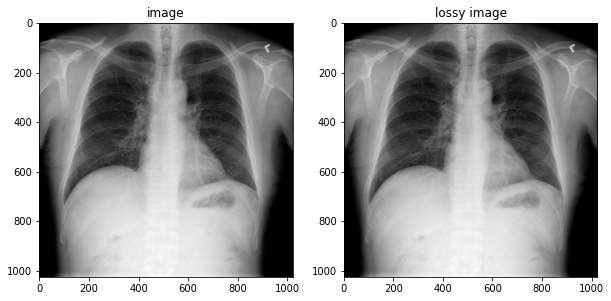

In [0]:


image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)

skipped = tfio.image.decode_dicom_image(image_bytes, on_error='skip', dtype=tf.uint8)

lossy_image = tfio.image.decode_dicom_image(image_bytes, scale='auto', on_error='lossy', dtype=tf.uint8)


fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(np.squeeze(image.numpy()), cmap='gray')
axes[0].set_title('image')
axes[1].imshow(np.squeeze(lossy_image.numpy()), cmap='gray')
axes[1].set_title('lossy image');

In [0]:
tfms = get_transforms()

In [0]:
np.random.seed(7)
data = ImageDataBunch.from_folder(path_images, size=256, bs=bs, ds_tfms=tfms).normalize(imagenet_stats) #valid='val', valid_pct=0.2,
                                  

IndexError: ignored

In [0]:
len(os.listdir(path_images))

26684

In [0]:
os.listdir(path_images)[0:10]

['f79e5a75-5e15-431a-9ba3-de64c1724b65.dcm',
 'f79fa94e-8886-425c-95d4-81abfea92aee.dcm',
 'f79fc759-fde0-4e2e-8951-26ac8af5ef89.dcm',
 'f7a169e2-a1a7-439a-ab83-0d34cf5ae4b9.dcm',
 'f7a172fc-a34f-4155-806d-7b0afe2a6156.dcm',
 'f7a1de8c-7802-4af3-98c4-4dfb088b986d.dcm',
 'f7a37b72-fda5-4adc-b3b0-968c923bc1c6.dcm',
 'f7a42b73-f909-4e1f-89dd-c776f45cdc40.dcm',
 'f7a488d3-34b2-4bcf-b61a-b4ad12c230e0.dcm',
 'f7a5fd29-dd8d-4f85-8164-69b2e83da35e.dcm']

ERROR! Session/line number was not unique in database. History logging moved to new session 59
     |████████████████████████████████| 35.3MB 99kB/s 


In [0]:
#https://www.kaggle.com/gpreda/rsna-pneumonia-detection-eda
#https://colab.research.google.com/drive/1reOc-bBi2CNBZ94rHsy86dMJbm9KwJGU
data_row_img = pydicom.dcmread(imagePath)

In [0]:
ds=pydicom.read_file(path_images/'0afef50e-63a7-4adf-9bc1-02f73612be56.dcm')


AttributeError: ignored

In [0]:
pylab.imshow(ds.pixel_array, cmap=pylab.cm.bone)
<matplotlib.image.AxesImage object at 0x0162A530>
pylab.show()

In [0]:
img = open_image(path_images/'0afef50e-63a7-4adf-9bc1-02f73612be56.dcm')#data/rsna/4b4d8179-7c0d-415f-bb11-5dbda89b5abe.dcm'#'val'/'NORMAL'/'NORMAL2-IM-1440-0001.jpeg')
#'/root/.fastai/data/rsna/5c26b94b-78f6-49ff-95a7-a2e4fce83778.dcm'
print(img.data.shape)
img.show()

UnidentifiedImageError: ignored

> /usr/local/lib/python3.6/dist-packages/PIL/Image.py(2862)open()
   2860         warnings.warn(message)
   2861     raise UnidentifiedImageError(
-> 2862         "cannot identify image file %r" % (filename if filename else fp)
   2863     )
   2864 

--KeyboardInterrupt--
--KeyboardInterrupt--
--KeyboardInterrupt--


In [0]:
!unzip path/stage_2_test_images.zip -d path_test

unzip:  cannot find or open path/stage_2_test_images.zip, path/stage_2_test_images.zip.zip or path/stage_2_test_images.zip.ZIP.


In [0]:
!unzip -q path/stage_2_test_images.zip -d path_test

unzip:  cannot find or open path/stage_2_test_images.zip, path/stage_2_test_images.zip.zip or path/stage_2_test_images.zip.ZIP.


In [0]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [0]:
#for data folder, works with unzipping method e.g. ! unzip -q -n {path}/stage_2_train_labels.csv.zip -d {path}
path = Config.data_path()/'rsna'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/rsna')

In [0]:
path_test = Config.data_path()/'rsna'/'test'
path_test.mkdir(parents=True, exist_ok=True)
path_test

PosixPath('/root/.fastai/data/rsna/test')

In [0]:
path_test = Path(base_dir + 'rsna/test')
#for folder in folders:
#path = Path(base_dir + 'rsna/test')
#dest = path/folder
path_test.mkdir(parents=True, exist_ok=True)

In [0]:
path = Path(base_dir + 'data/rsna')
path.mkdir(parents=True, exist_ok=True)
#dest = path/folder
#dest.mkdir(parents=True, exist_ok=True)

In [0]:
bs = 64

In [0]:
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/.ipynb_checkpoints'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/stage_2_train_labels.csv.zip'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/stage_2_train_images.zip'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/data/rsna/stage_2_test_images.zip')]

In [0]:
path = Path(base_dir + 'rsna')

In [0]:
os.chdir('/content/gdrive/My Drive/fastai-v3/data/rsna')

In [0]:
!unzip -q stage_2_train_labels.csv.zip -d path_test/

unzip:  cannot find or open stage_2_train_labels.csv.zip, stage_2_train_labels.csv.zip.zip or stage_2_train_labels.csv.zip.ZIP.


In [0]:
! unzip -q -n {path}/stage_2_train_labels.csv.zip -d {path_test}

unzip:  cannot find or open /content/gdrive/My, /content/gdrive/My.zip or /content/gdrive/My.ZIP.


In [0]:
! unzip -q -n {path}/stage_2_test_images.zip -d {path}

In [0]:
! unzip -q -n {path}/stage_2_train_labels.csv.zip -d {path}

In [0]:
#path = Path('../input/chest_xray/chest_xray')
#path.ls()

In [0]:
img = open_image(path/5c26b94b-78f6-49ff-95a7-a2e4fce83778.dcm)#data/rsna/4b4d8179-7c0d-415f-bb11-5dbda89b5abe.dcm'#'val'/'NORMAL'/'NORMAL2-IM-1440-0001.jpeg')
#'/root/.fastai/data/rsna/5c26b94b-78f6-49ff-95a7-a2e4fce83778.dcm'
print(img.data.shape)
img.show()

SyntaxError: ignored